# Titanic - Machine Learning from Disaster

This project is to attempt to predict who lived and who died based on their other data, such as: gender, class, age, etc.	
The only columns that might need some explanation are mentioned below.

- sibsp	# of siblings / spouses aboard the Titanic	
- parch	# of parents / children aboard the Titanic	

In [25]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [26]:
train = pd.read_csv('train.csv')

In [27]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB


In [29]:
train[['Age', 'SibSp', 'Parch', 'Fare']].describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


## Data Cleaning

Looks like we'll need to clean some of this up, I'll do the following steps to clean it up:
1. Remove the cabin column, there's only 204 non-null values
2. Replace NaN age values with the mean age.
3. Remove the few rows that have null Embarked

In [30]:
train.drop(['Cabin'], axis=1, inplace=True)

In [31]:
train['Age'].fillna(train['Age'].mean(), inplace=True)

In [32]:
train.dropna(inplace=True)

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 69.5+ KB


## Data Exploration

It's time to dig into the data to determine any insights or correlations before starting the Machine Learning section of the project.

<AxesSubplot:title={'center':'Survival by Gender'}, xlabel='Sex'>

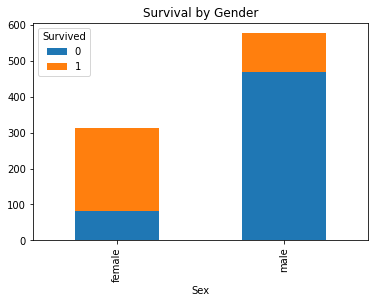

In [34]:
pd.crosstab(train['Sex'], train['Survived']).plot.bar(title = 'Survival by Gender', stacked=True)

### Survival by Sex

There were more males on board the titanic but it looks like more females ended up surviving. This lines up with historical recounting of the Titanic tales of women and children being allowed to get on the lifeboats first.

<AxesSubplot:title={'center':'Survival by Class'}, xlabel='Pclass'>

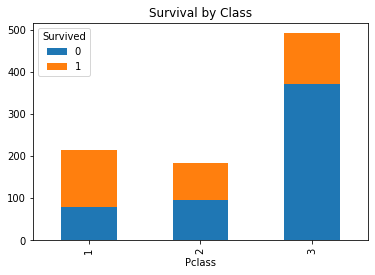

In [35]:
pd.crosstab(train['Pclass'], train['Survived']).plot.bar(title = 'Survival by Class', stacked=True)

### Survival by Class

Seems there was a higher chance of survival if the passenger happened to be a part of the 1st class. This isn't a surprise though this is just a quick glance and not actual hypothesis testing yet.

<AxesSubplot:title={'center':'Survival by Embarked'}, xlabel='Embarked'>

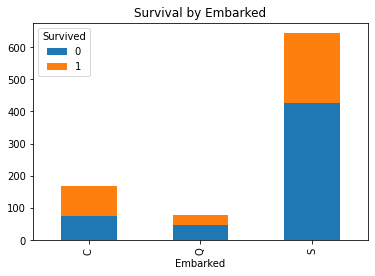

In [36]:
pd.crosstab(train['Embarked'], train['Survived']).plot.bar(title = 'Survival by Embarked', stacked=True)

In [63]:
print('Southampton: ' + str(train[(train['Embarked'] == 'S') & (train['Survived'] == 0)]['PassengerId'].count()
            /train.loc[train['Embarked'] == 'S']['PassengerId'].count()))
print('Cherbourg: ' + str(train[(train['Embarked'] == 'C') & (train['Survived'] == 0)]['PassengerId'].count()
            /train.loc[train['Embarked'] == 'C']['PassengerId'].count()))
print('Queenstown: ' + str(train[(train['Embarked'] == 'Q') & (train['Survived'] == 0)]['PassengerId'].count()
            /train.loc[train['Embarked'] == 'Q']['PassengerId'].count()))


Southampton: 0.6630434782608695
Cherbourg: 0.44642857142857145
Queenstown: 0.6103896103896104


### Survival by Port of Embarkation

Looks like there was a higher survival percentage from the people that embarked from Southampton. I think I'll need to label encode this so I can look at the correlation matrix and see if this and some other feature are correlated, possibly the Fare feature. It's possible that the more wealthy departed from this Southampton area while more of the less fortunate passengers embared from Cherbourg.

<AxesSubplot:title={'center':'Survival by Age'}, ylabel='Frequency'>

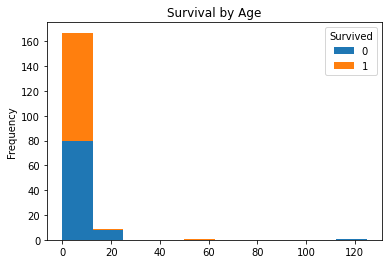

In [64]:
pd.crosstab(train['Age'], train['Survived']).plot.hist(title = 'Survival by Age', stacked=True)

<AxesSubplot:title={'center':'Survival by Embarked'}, xlabel='SibSp'>

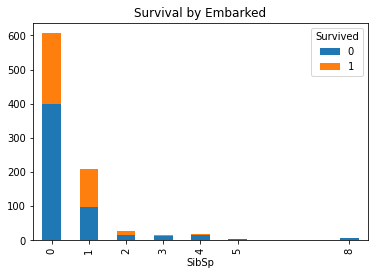

In [38]:
pd.crosstab(train['SibSp'], train['Survived']).plot.bar(title = 'Survival by Embarked', stacked=True)

<AxesSubplot:title={'center':'Survival by Embarked'}, xlabel='Parch'>

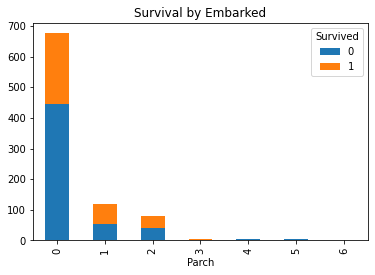

In [39]:
pd.crosstab(train['Parch'], train['Survived']).plot.bar(title = 'Survival by Embarked', stacked=True)

<AxesSubplot:>

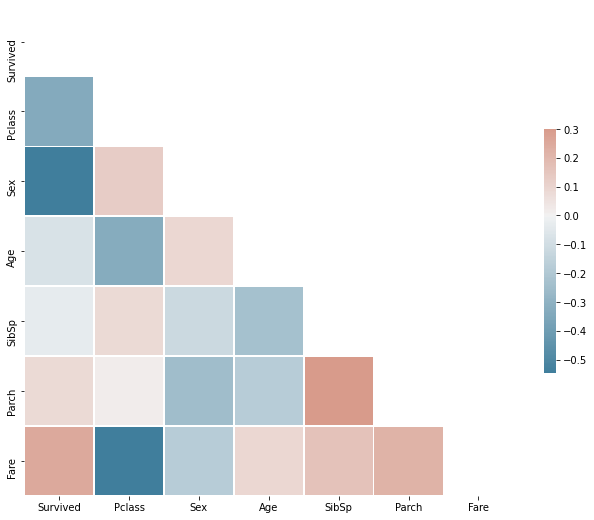

In [40]:
# Compute the correlation matrix
# Conver gender to number real quick to look at in correlation matrix
train_corr = train
train_corr['Sex'] = train['Sex'].map({'male': 1, 'female': 0})

corr = train.drop('PassengerId', axis=1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Correlation Analysis

There's some interesting correlation in the matrix above which leads me to believe that I need to combine some columns or drop some altogether so that the ML model isn't manipulated too heavily one way because of 2 different features that are closely related.

- Pclass and Fare seem to be strongly negatively correlated which would make sense, the higher the priced ticket, the more likely it belonged to a Pclass of 1 or 1st class or Upper class socio-economic person. I might look at dropping Fare or thinking of a way to combine them.
- SibSp and Parch were somewhat positively correlated or the count of siblings and spouses were somewhat possitively correlated with the count of parents and children on board. These 2 fields will probably be combined for ML.
- Looking at just the Survived correlation, it seems likely that your socio-economic status had a relatively large impact on whether you survived or not. 
- Gender seems to be strongly negatively correlated with survival as well. Females were encoded as a 0 and survival is a 1 and since we can see there definitely seems to be a much higher chance of survival if the passenger was a female then the correlation makes sense.